# Reconstruction test  
ACAE was trained for 100 epochs 

In [1]:
import argparse
from argparse import RawTextHelpFormatter
import numpy as np
import os

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, UpSampling2D, Conv2DTranspose, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.optimizers import Adam

from absl import app


# logging
import wandb
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors
import shutil
from glob import glob

Using TensorFlow backend.


## Load models

In [2]:
encoder = load_model("/home/aogorodnikov/aae/encoder.h5")
decoder = load_model("/home/aogorodnikov/aae/decoder.h5")
discriminator = load_model("/home/aogorodnikov/aae/discriminator.h5")
generator = load_model("/home/aogorodnikov/aae/generator.h5")

Instructions for updating:
Colocations handled automatically by placer.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.cast instead.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## Notes  
We need to set basic parameters for input data, like dimensions, number of filters (3 for RGB)  
Also we compile the models

In [3]:
input_dim = (104,104,3)
latent_dim=32

# compile imported models into assembled autoencoder
autoencoder_input = Input(shape=input_dim)
autoencoder = Model(autoencoder_input, decoder(encoder(autoencoder_input)))
autoencoder.compile(optimizer=Adam(lr=1e-4), loss="mean_squared_error", metrics=['accuracy'])
discriminator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy'])

## Notes  
We create a function that takes a single class (cellular phenotype) and test reconstruction loss for autoencoder and discriminator

In [4]:
def anomaly_score(cell_pheno):
    [shutil.rmtree(x) for x in glob("/home/aogorodnikov/test/*")]
    input_dir = os.path.join("/home/aogorodnikov/classes_rgb_corrected/", cell_pheno)
    shutil.copytree(input_dir, os.path.join("/home/aogorodnikov/test/", cell_pheno))
    img_wd = "/home/aogorodnikov/test"
    batch = 56
    input_dim = (104,104,3)
    data_loader = ImageDataGenerator(
        rescale=1. / 255,
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    train_data = data_loader.flow_from_directory(
        img_wd,
        target_size=(input_dim[0], input_dim[0]),
        batch_size=batch,
        class_mode='input')
    
    batch_index = 0
    discriminator_batch_losses = []
    while batch_index <= train_data.batch_index:
        data = train_data.next()
        data_list = data[0]
        data_size = len(data_list)

        fake_latent = encoder.predict(data_list)
        discriminator_input = np.concatenate((fake_latent, np.random.randn(data_size, latent_dim) * 5.))
        discriminator_labels = np.concatenate((np.zeros((data_size, 1)), np.ones((data_size, 1))))
        discriminator_history = discriminator.evaluate(x=discriminator_input, y=discriminator_labels)

            
        batch_index = batch_index + 1
        discriminator_batch_losses.append(discriminator_history[0])
    
    
    
    
    ae_res = autoencoder.evaluate_generator(train_data)[0]
    adv_res = np.mean(discriminator_batch_losses)
    
    print('Class: {}\nae_loss: {}\nadv_loss: {}'.format(cell_pheno, ae_res, adv_res))
    return [ae_res, adv_res]
    
        

## Notes  
We create a list of thise class directories and deploy the function above in list comprehension logic

In [5]:
dirs = [x for x in os.listdir("/home/aogorodnikov/classes_rgb_corrected/") if os.path.isdir(os.path.join("/home/aogorodnikov/classes_rgb_corrected/", x))]
results = [[x, anomaly_score(cell_pheno=x)] for x in dirs]

Found 1365 images belonging to 1 classes.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


42/42 [==============================] - 0s 292us/step
Class: confluent
ae_loss: 0.003999746390260183
adv_loss: 0.7838552573181334
Found 313 images belonging to 1 classes.
66/66 [==============================] - 0s 278us/step
Class: cytokinesis
ae_loss: 0.004865132601033099
adv_loss: 0.8199764293595653
Found 5616 images belonging to 1 classes.
32/32 [==============================] - 0s 164us/step
Class: negative
ae_loss: 0.0028489736542954744
adv_loss: 0.7394266509605096
Found 310 images belonging to 1 classes.
60/60 [==============================] - 0s 257us/step
Class: nuclear_mess
ae_loss: 0.005030986928050557
adv_loss: 0.8409712989178916
Found 4287 images belonging to 1 classes.
62/62 [==============================] - 0s 257us/step
Class: large_nuclei
ae_loss: 0.003895421010538317
adv_loss: 0.8245990864606582
Found 1077 images belonging to 1 classes.
26/26 [==============================] - 0s 183us/step
Class: other
ae_loss: 0.0028547980172339976
adv_loss: 0.751026201248169
Fo

## Notes  
Printed results show adversarial and autoencoder losses fpr each class

In [6]:
results

[['confluent', [0.003999746390260183, 0.7838552573181334]],
 ['cytokinesis', [0.004865132601033099, 0.8199764293595653]],
 ['negative', [0.0028489736542954744, 0.7394266509605096]],
 ['nuclear_mess', [0.005030986928050557, 0.8409712989178916]],
 ['large_nuclei', [0.003895421010538317, 0.8245990864606582]],
 ['other', [0.0028547980172339976, 0.751026201248169]],
 ['micronuclei', [0.004372820632750762, 0.8483473320175411]],
 ['spindle', [0.0031876518758533357, 0.7453198668950782]],
 ['Y', [0.004116984437022245, 0.7382923630305699]],
 ['binucleated', [0.0037007886567153037, 0.8000463188758918]],
 ['new_neg', [0.003238311602086066, 0.7691261381689285]],
 ['polarity', [0.003786890348419547, 0.7517852736370904]],
 ['croissant', [0.0036426187203740055, 0.7521523842376466]]]

[(0, 1.8)]

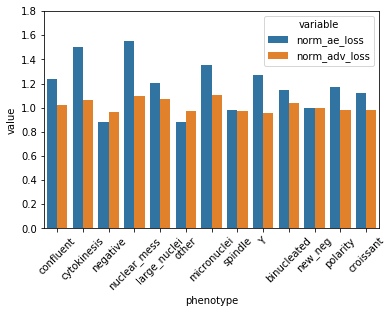

In [8]:
import pandas as pd
import seaborn as sns

res_dict = {x[0]: x[1] for x in results}
res_df = pd.DataFrame(res_dict, index=["ae_loss", "adv_loss"]).transpose()
res_df['phenotype'] = res_df.index
res_df['norm_ae_loss'] = res_df.ae_loss / float(res_df.loc[res_df.phenotype=='new_neg','ae_loss'])
res_df['norm_adv_loss'] = res_df.adv_loss / float(res_df.loc[res_df.phenotype=='new_neg','adv_loss'])
res_df.drop(['ae_loss', 'adv_loss'], axis=1, inplace=True)
res_melt = pd.melt(res_df,id_vars="phenotype")

# plotting
ax = sns.barplot(x='phenotype', y='value', hue='variable', data=res_melt)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(ylim=(0, 1.8))

In [8]:
rec_loss = [x[1][0] for x in results]
adv_loss = [x[1][1] for x in results]

In [9]:
np.percentile(rec_loss, 60)

0.003954619914293289

In [ ]:
np.percentile(adv_loss, 60)

# Conclusions  
1. *Negative* class has the smallest autoencoder and a small adversarial loss.  
2. An anomaly will be determined by the logic `if {dv_loss OR rec_loss} > 60'th percentile` 

In [12]:
img_wd = "/home/aogorodnikov/test/"
batch = 56
input_dim = (104,104,3)
latent_dim=32
epoch = 10
conv=True
adversarial=True


In [13]:
# LOAD DATA
data_loader = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_data = data_loader.flow_from_directory(
    img_wd,
    target_size=(input_dim[0], input_dim[0]),
    batch_size=batch,
    class_mode='input')

Found 1 images belonging to 1 classes.


In [14]:
data = train_data.next()
data_list = data[0]
fake_latent = encoder.predict(data_list)

In [15]:
def draw(samples):
    fig = plt.figure(figsize=(5 * len(samples), 5))
    gs = gridspec.GridSpec(1, len(samples))
    for i, sample in enumerate(samples):
        ax = plt.Subplot(fig, gs[i])
        ax.imshow((sample["image"] * 255.).astype("int"), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title(sample["title"])
        fig.add_subplot(ax)
    plt.show(block=False)

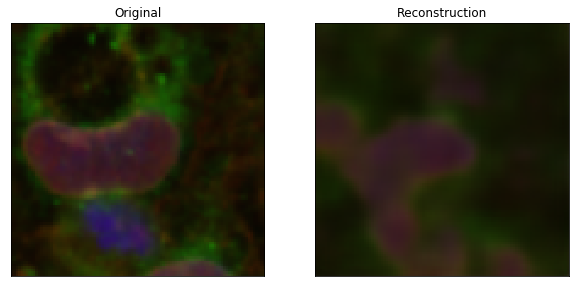

In [18]:
#choice = np.random.choice(np.arange(32))
choice = 0
original = data_list[choice]

original_1 = np.expand_dims(original, axis=0)

latent = encoder.predict(original_1)

reconstruction = decoder.predict(latent)

draw([{"title": "Original", "image": original}, {"title": "Reconstruction", "image": reconstruction[0]}])

